In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_ffnn, train, get_all_accuracy_rates, allocate_x_batch_ffnn, quantile_score, get_competition_preds


nn_type = 'ffnn'
allocate_x_batch = allocate_x_batch_ffnn
get_x_sequences = get_x_sequences_ffnn

In [2]:
np.random.seed(2021)

case=1
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 6*4+1


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
2016-01-01 20:00:00
2017-01-07 20:15:00
137893


In [3]:
input_size = x.shape[1] * pred_seq_len
hidden_size = 50
num_hidden = 2
out_size = 1
drop_p = 0

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        self.input_linear = nn.Linear(in_features=input_size,
                                      out_features=hidden_size,
                                      bias=True)
        self.output_linear = nn.Linear(in_features=hidden_size,
                                       out_features=out_size,
                                       bias=True)
        self.hidden_list = []
        for i in range(num_hidden):
            self.hidden_list.append(nn.Linear(in_features=hidden_size,
                                              out_features=hidden_size,
                                              bias=True))
        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        x = self.input_linear(x)
        x = self.dropout(x)
        x = self.act(x)
        for hidden_layer in self.hidden_list:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.act(x)
        x = self.output_linear(x)
        
        return x


net = Net()
print(net)


Net(
  (input_linear): Linear(in_features=400, out_features=50, bias=True)
  (output_linear): Linear(in_features=50, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0)
)


In [4]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1000
num_epochs = 10
k_fold_size = 2

loss = nn.MSELoss()
#loss = nn.L1Loss()


optim_params = {'lr': 3e-3, 'weight_decay': 0}
train_loss, valid_loss, net = train(nn_type, x, y, Net, optim_params, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, case)
valid_loss[0] = np.sqrt(valid_loss[0])

#np.savez(outfile, train_loss=train_loss, valid_loss=valid_loss)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Fold 0: Training loss: 0.0296, 
Validation metrics: 
mseloss 0.0301 
maeloss 0.1284 
quantile_score_metric 0.0641 
accuracy_rate_metric 0.8267 

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Fold 1: Training loss: 0.0291, 
Validation metrics: 
mseloss 0.0296 
maeloss 0.1257 
quantile_score_metric 0.0619 
accuracy_rate_metric 0.8280 



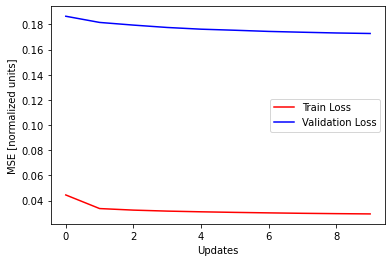

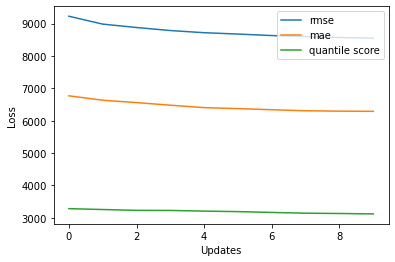

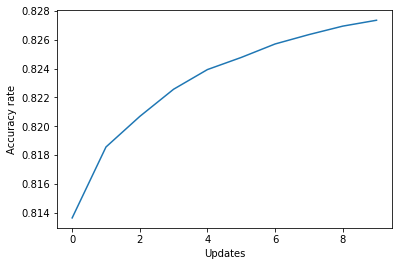

In [5]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss[:,:].mean(axis=-1), 'r', epoch, valid_loss[:,:,:].mean(axis=-1)[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()


plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:,:,:].mean(axis=-1)[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[:,:,:].mean(axis=-1)[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


In [6]:
x_batch = allocate_x_batch(len(good_idx), input_size, pred_seq_len)
predictions = net(get_x_sequences(good_idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()

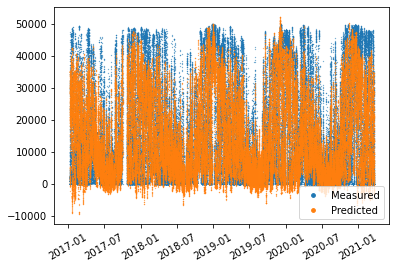

In [7]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [8]:
x_batch = allocate_x_batch(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences, good_idx, idx_offset, pred_seq_len, case)



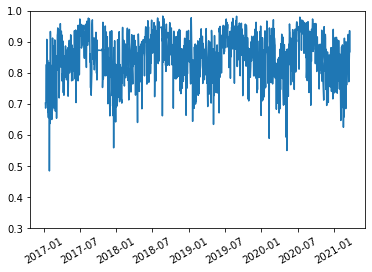

Mean accuracy rate 0.8501553


In [9]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))

In [10]:
day=0
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)